# Construct Kaplan-Meier Curve and Survival Model from Published Life Table
**Use case: Rare disease symptom onset data**

## Import necesssary modules

In [1]:
import lifelines # fit Kaplan-Meier curve for ILD data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Input Life Table

The life table was extracted from the literature (source link).

The life table represent longitudinal patient nunmber live with a specific symptom of interest, during the follow-up up to five years.

The life table presents patients number suvived the symptom of interest from year 1 through 5, with patient number at risk the year 0 when corresponding the index year (or date) of the retrospective cohort.

In [18]:
patient_at_risk = [745, 592, 382, 262, 171, 97]

data = {
    "year": [0, 1, 2, 3, 4, 5],
    "symptoms_free": patient_at_risk
}

df = pd.DataFrame(data)
print(df)

   year  symptoms_free
0     0            745
1     1            592
2     2            382
3     3            262
4     4            171
5     5             97


## Compute event per interval

Next, we need to back calculate patient number present the symptom or not during individual time interval.

We assume that there is no patients scencored, and only have binary status, either with or without the symptom. Therefore, the event number is symptom free number of last year substract symptom free number of the current year. 

For example, the events number of year 1 equals symptom-free patient number of year 0 minus symptom-free patient number of year 1. 

In [19]:
# --- Compute events per interval --- #
df["events"] = df["symptoms_free"].shift(1) - df["symptoms_free"]
df.loc[0, "events"] = 0  # no event at time 0
print(df)

   year  symptoms_free  events
0     0            745     0.0
1     1            592   153.0
2     2            382   210.0
3     3            262   120.0
4     4            171    91.0
5     5             97    74.0


## Creat expanded individual-patient data

Next, we re-crete individual level dataset, containing observed timing, whether symptom-free status, with each row representing each individual. Use the coding 1 to represent patient appear symptom while the coding 0 patient free of symptom.

In [20]:
# --- Create expanded individual-level dataset for lifelines --- #
records = []
for _, row in df.iterrows():
    year = row["year"]
    events = int(row["events"])
    # event cases
    for i in range(events):
        records.append({"time": year, "event": 1})
for i in range(int(df.iloc[-1]["symptoms_free"])):
    records.append({"time": 5, "event": 0})

df_long = pd.DataFrame(records)


We verify whether the created table contains accurate patient number at risk (n=745).

In [21]:
df_long.shape

(745, 2)

We furter insepct patient disbutions between symptom-free and appearing symptom within invidial time intervals.

In [22]:
df_long.value_counts()

time  event
2.0   1        210
1.0   1        153
3.0   1        120
5.0   0         97
4.0   1         91
5.0   1         74
Name: count, dtype: int64

## Fit Kaplan-Meier survival function

Now the table is ready for fitting Kaplan-Meier model.

In [30]:
# --- Fit Kaplan-Meier --- #
from lifelines import KaplanMeierFitter

km = KaplanMeierFitter()
km.fit(durations=df_long["time"], event_observed=df_long["event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 745 total observations, 97 right-censored observations>

### Visualize Kaplan-Meier model

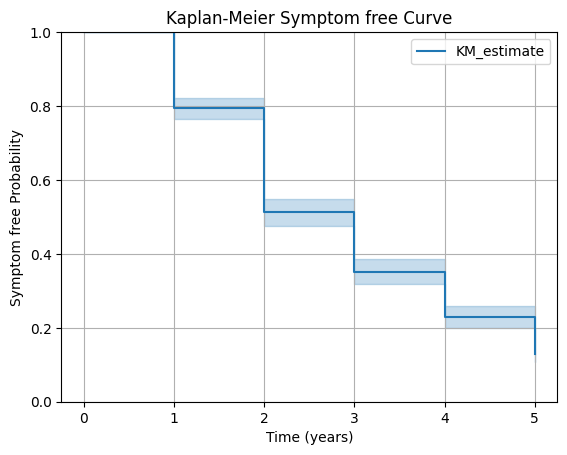

In [24]:
# --- Plot --- #
km.plot_survival_function()
plt.title("Kaplan-Meier Symptom free Curve")
plt.xlabel("Time (years)")
plt.ylabel("Symptom free Probability")
plt.ylim(0, 1)
plt.grid()
plt.show()

### Estimate median symptom-free time

In [25]:
print("Median Symptom free Time:", km.median_survival_time_)

Median Symptom free Time: 3.0
